In [ ]:
# Let's keep our notebook clean, so it's a little more readable!
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline
# %matplotlib notebook

# Using machine learning to predict age from rs-fmri

The goal is to extract data from several rs-fmri images, and use that data as features in a machine-learning model. We will integrate what we've learned in the previous machine-learning lecture to build an unbiased model and test it on a left out sample.

Link to slides: https://figshare.com/s/4d9953055c9ed36301ad#/articles/9162428

## 1. Load the data

<img src="Imgs/SampFeat.png" alt="terms" width="300"/>

In [3]:
# change this to the location where you downloaded the data
wdir = '/Users/estefanysuarez/Downloads/coding/NeuroDataSci-course-2019-master/content/day4/PM/'

### Load input features - X matrix

In [4]:
import numpy as np

feat_file = 'MAIN_BASC064_subsamp_features.npz'
X_features = np.load(feat_file)['a']

n_samples, n_features = X_features.shape
print(f'Our data set contains {n_samples} samples and {n_features} features.')

Our data set contains 155 samples and 2016 features.


Now that we've got our features, we can visualize them as a matrix!

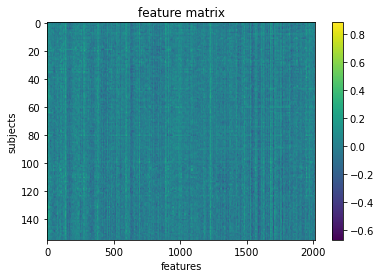

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')
plt.show()
plt.close()

### Load output labels (our target data) - Y vector

In [6]:
import os
import pandas

# Let's load the phenotype data
pheno_path = os.path.join(wdir, 'participants.tsv')

pheno = pandas.read_csv(pheno_path, sep='\t').sort_values('participant_id')
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM Booklet-Matched,ToM Booklet-Matched-NOFB,FB_Composite,FB_Group,WPPSI BD raw,WPPSI BD scaled,KBIT_raw,KBIT_standard,DCCS Summary,Scanlog: Scanner,Scanlog: Coil,Scanlog: Voxel slize,Scanlog: Slice Gap
0,sub-pixar001,4.774812,4yo,child,M,R,0.80,0.736842,6.0,pass,22.0,13.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
1,sub-pixar002,4.856947,4yo,child,F,R,0.72,0.736842,4.0,inc,18.0,9.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.1
2,sub-pixar003,4.153320,4yo,child,F,R,0.44,0.421053,3.0,inc,15.0,9.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
3,sub-pixar004,4.473648,4yo,child,F,R,0.64,0.736842,2.0,fail,17.0,10.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.2
4,sub-pixar005,4.837782,4yo,child,F,R,0.60,0.578947,4.0,inc,13.0,5.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.2


Looks like there is a column labeling age. Let's capture it in a variable!

In [7]:
y_age = pheno['Age']

Maybe we should have a look at the distribution of our target variable!

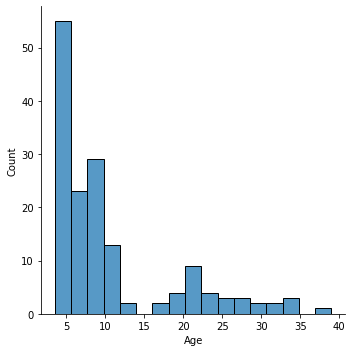

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(y_age)
plt.show()

## 2. Prepare data for machine-learning

Here, we will divide our data set into *training* and *test* sets. We will use the training set to fit and tweak our model's parameters. The test set will be exclusively used to validate our model, and therefore it will be set aside and **WE WILL NOT TOUCH IT UNTIL THE VERY END!!!**. 

<img src="Imgs/splitdata.png" alt="terms" width="300"/>

Now, we want to be sure that our training and test samples are matched! 
We can do that with a "stratified split". This dataset has a variable indicating AgeGroup. We can use that to make sure our training and testing sets are balanced!

In [9]:
age_class = pheno['AgeGroup']
age_class.value_counts()

5yo       34
8-12yo    34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

# Split the sample into training/test sets with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

X_train, X_test, y_train, y_test = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('Training sample:', len(X_train))
print('Test sample:', len(X_test))

Training sample: 93
Test sample: 62


Let's visualize the distributions to be sure they are matched

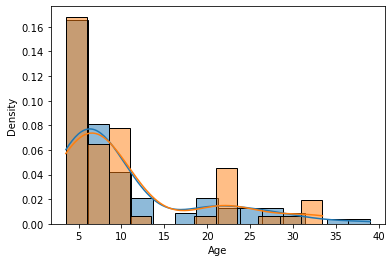

In [11]:
sns.histplot(y_train, label='train', stat='density', kde=True, color=sns.color_palette()[0])
sns.histplot(y_test, label='test', stat='density', kde=True, color=sns.color_palette()[1])
plt.show()
plt.close()

## 3. Train your first ML model!

Machine-learning can get fancy pretty quickly. We'll start with a fairly standard regression model called a **Support Vector Regressor (SVR)**. 

While this may seem unambitious, simple models can be very robust. And we probably don't have enough data to create more complex models (but we can try later).

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

Let's fit our first model!

<img src="Imgs/modfit.png" alt="terms" width="400"/>

In [12]:
from sklearn.svm import SVR

# define the model
l_svr = SVR(kernel='linear') 

# fit the model
l_svr.fit(X_train, y_train) 

SVR(kernel='linear')

## 4. Validate your model
Well... that was easy. Now let's see how well the model learned the data!


<img src="Imgs/modval.png" alt="terms" width="800"/>

But, two questions first:

1. What happens if I validate my model with my **test** set? 
2. What happens if I validate my model with the **train** set?

Let's try with the **training** set:

In [13]:
# predict the training data based on the model
y_pred = l_svr.predict(X_train) 

# caluclate the model accuracy
acc = l_svr.score(X_train, y_train) # the default score for the SVR model is the coefficient of determination R2

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true=y_train,y_pred=y_pred)

Let's view our results and plot them all at once!

Accuracy (R2) =  0.9998486731363846
MAE           =  0.09830411993987148


Text(0.5, 0, 'Predicted Age')

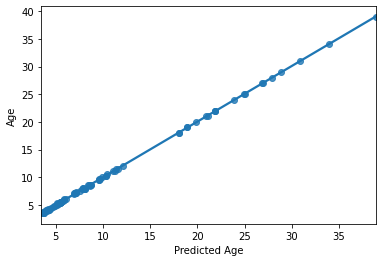

In [14]:
# print results
print('Accuracy (R2) = ', acc) 
print('MAE           = ', mae) 

sns.regplot(y_pred,y_train)
plt.xlabel('Predicted Age')
# plt.show()

HOLY COW! Machine-learning is amazing!!! Almost a perfect fit :O ... which means there's must be something wrong. What's the problem here?

## 5. Let's create a validation set (CV)
<img src="Imgs/CV.png" alt="terms" width="300"/>

In [15]:
from sklearn.model_selection import train_test_split

# Split the sample into training/validation sets with a 75/25 ratio, and 
# stratify by age class, and also shuffle the data.

age_class2 = pheno.loc[y_train.index,'AgeGroup']

X_train2, X_val, y_train2, y_val = train_test_split(
                                                    X_train, # x
                                                    y_train, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class2,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our new training and validation groups
print('(New) Training sample:', len(X_train2))
print('Validation sample:', len(X_val))

(New) Training sample: 69
Validation sample: 24


In [16]:
from sklearn.metrics import mean_absolute_error

# fit model just to training data
l_svr.fit(X_train2,y_train2)

# predict the *test* data based on the model trained on X_train2
y_pred = l_svr.predict(X_val) 

# caluclate the model accuracy
acc = l_svr.score(X_val, y_val) 
mae = mean_absolute_error(y_true=y_val,y_pred=y_pred)

CV accuracy (R2) =  0.6396080261333338
CV MAE           =  3.3741771722133342


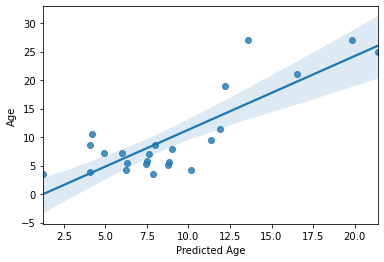

In [17]:
# print results
print('CV accuracy (R2) = ', acc)
print('CV MAE           = ', mae)

sns.regplot(y_pred,y_val)
plt.xlabel('Predicted Age')
plt.show()

Not perfect, but as predicting with unseen data goes, not too bad! Especially with a training sample of "only" 69 subjects. But we can do better in terms of estimating the accuracy of our model's performance!

For example, we can "increase" the size of our training set by using 10-fold cross-validation (CV) instead. 

## 6. Using k-fold CV to accurately assess model performance

<img src="Imgs/KCV1.png" alt="terms" width="900"/>

In [18]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# estimate CV scores
n_folds = 10
acc = cross_val_score(l_svr, X_train, y_train, cv=n_folds)
mae = cross_val_score(l_svr, X_train, y_train, cv=n_folds, scoring='neg_mean_absolute_error')
print(f"average ({n_folds}-fold) CV accuracy (R2) = %0.2f and standard deviation of %0.2f" % (acc.mean(), acc.std()))
print(f"average ({n_folds}-fold) CV MAE           = %0.2f and standard deviation of %0.2f" % (mae.mean(), mae.std()))

average (10-fold) CV accuracy (R2) = -0.07 and standard deviation of 1.53
average (10-fold) CV MAE           = -3.32 and standard deviation of 0.92


We can also look at the accuracy of the predictions for each fold of the cross-validation:

In [19]:
for i in range(n_folds):
    print('Fold {} -- Acc = {}, MAE = {}'.format(i, acc[i], mae[i]))

Fold 0 -- Acc = -2.17104851723455, MAE = -3.1879669010630614
Fold 1 -- Acc = 0.46422338756678183, MAE = -3.6195731719099262
Fold 2 -- Acc = 0.6399947657598235, MAE = -3.77877466734986
Fold 3 -- Acc = 0.6066320814146724, MAE = -2.460581706408866
Fold 4 -- Acc = 0.6849372683249586, MAE = -4.58758315050142
Fold 5 -- Acc = 0.7897688515442703, MAE = -3.3308975542451527
Fold 6 -- Acc = 0.46091049550218677, MAE = -4.876012953479923
Fold 7 -- Acc = 0.893121074294786, MAE = -1.8602214199607374
Fold 8 -- Acc = -3.884559214311814, MAE = -3.322805664971417
Fold 9 -- Acc = 0.8326125328465797, MAE = -2.2079438605567914


Or we can also look at the overall accuracy of the model. In this case the data is split according to the cv parameter. Each sample belongs to exactly one test set, and its prediction is computed with the model fitted on the corresponding training set.

Overall CV R2: 0.6444246950487118
Overall CV MAE: 3.3298662816596476


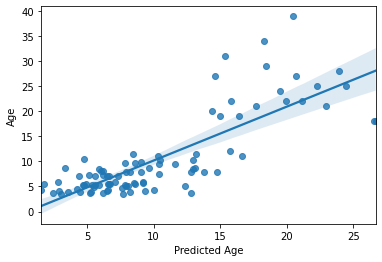

In [20]:
from sklearn.metrics import r2_score

y_pred = cross_val_predict(l_svr, X_train, y_train, cv=n_folds) # here we use our original training set
overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)

print('Overall CV R2:', overall_acc)
print('Overall CV MAE:', overall_mae)

sns.regplot(y_pred, y_train)
plt.xlabel('Predicted Age')
plt.show()

## 7. Tweak your model - Using k-fold CV for model selection

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's fine to try out different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

It is not uncommon to try other models, or tweak hyperparameters. In this case, due to our relatively small sample size, we are probably not powered sufficiently to do so, and we would once again risk overfitting. However, for the sake of demonstration, we will do some tweaking. 

<img src="Imgs/KCV2.png" alt="terms" width="400"/>

In [21]:
from sklearn.svm import SVR

# define models and set hyperparameters
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

models = {'svr_lin':svr_lin, 'svr_rbf':svr_rbf, 'svr_poly':svr_poly}

# perform k-fold CV with each model and evaluate performance
n_folds = 10
for name, model in models.items():
    print(f'\nPerformance for the {name.upper()} model:')
    acc = cross_val_score(model, X_train, y_train, cv=n_folds)
    mae = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='neg_mean_absolute_error')
    print(f" average ({n_folds}-fold) CV accuracy (R2) = %0.2f with a standard deviation of %0.2f" % (acc.mean(), acc.std()))
    print(f" average ({n_folds}-fold) CV MAE           = %0.2f with a standard deviation of %0.2f" % (mae.mean(), mae.std()))
    


Performance for the SVR_LIN model:
 average (10-fold) CV accuracy (R2) = -0.07 with a standard deviation of 1.53
 average (10-fold) CV MAE           = -3.32 with a standard deviation of 0.92

Performance for the SVR_RBF model:
 average (10-fold) CV accuracy (R2) = -0.88 with a standard deviation of 1.88
 average (10-fold) CV MAE           = -6.06 with a standard deviation of 1.83

Performance for the SVR_POLY model:
 average (10-fold) CV accuracy (R2) = 0.28 with a standard deviation of 0.73
 average (10-fold) CV MAE           = -3.30 with a standard deviation of 0.99


According to our k-fold CV analyses, the *best* candidate is the **Support Vector Regressor** model with a **polynomial** kernel. Note however that the SVR model possess a number of *hyperparameters* that could be tuned to potentially improve our predictions. Let's try this! 

## 8. Tweak your model - Using k-fold CV for hyperparameter tuning

To tune our model hyperparameters we can combine grid searh and cross validation!

<img src="Imgs/KCV3.png" alt="terms" width="400"/>

In [23]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# let's create our grid search 
tunning_params = [{'kernel': ['poly'], 'gamma': [1e-3, 1e-4],
                   'C': [1, 10, 100, 1000], 'degree':[2,3,4,5], 'epsilon':[.1], 'coef0':[1]}]

print("Tuning hyper-parameters ... ")
clf = GridSearchCV(estimator=SVR(), param_grid=tunning_params)#, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train)

print("\nGrid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
print(f"\nBest score (R2): {clf.best_score_}")
# print(f"\nBest score (MAE): {clf.best_score_}")
print("Best parameters set found on development set:")
print(clf.best_params_)

Tuning hyper-parameters ... 

Grid scores on development set:
-0.145 (+/-0.387) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
-0.194 (+/-0.398) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
-0.113 (+/-0.382) for {'C': 1, 'coef0': 1, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
-0.191 (+/-0.397) for {'C': 1, 'coef0': 1, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
-0.081 (+/-0.376) for {'C': 1, 'coef0': 1, 'degree': 4, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
-0.188 (+/-0.396) for {'C': 1, 'coef0': 1, 'degree': 4, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
-0.051 (+/-0.374) for {'C': 1, 'coef0': 1, 'degree': 5, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
-0.186 (+/-0.395) for {'C': 1, 'coef0': 1, 'degree': 5, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
0.185 (+/-0.339) for {'C': 10, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001

Thanks to our combined *k*-fold CV + Grid Search analysis, we have found the *best* model and the *best* set of model hyperparameters that maximize our (cross-validated) accuracy score, now what? 

## 9.  Ensemble methods and the *Bias-Variance* trade-off with 

Now that we have selected the model and its hyper-parameters, we can now use ensemble methods, such as **bagging** and **boosting**, to improve the bias-variance trade-off of our model. 

In general, ensemble methods provide a way to reduce overfitting. **Bagging** improves the trade-off between bias and variance by slightly increasing the bias term, but allowing for a larger reduction of the variance term, which generally results in a lower overall error. Thefore **bagging** methods are better suited for **strong and complex** models in which the variance is high. 

On the other hand, **Boosting** improves the trade-off between bias and variance by slightly increasing the variance term, but allowing for a larger reduction of the bias term, which generally results in a lower overall error. Hence, **boosting** methods usually work best with with **weak and simple** models in which the bias is high. 

<img src="Imgs/ensemble.png" alt="terms" width="700"/>

### Single estimator

In [24]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# np.random.seed(0)

# new partition of the data
X_train, X_val, y_train, y_val = train_test_split(
                                                  X_features, 
                                                  y_age, 
                                                  test_size = 0.1,  
                                                  shuffle = True, 
                                                  stratify = age_class,
                                                  )
# single SVR model
svr = SVR(kernel='poly', C=100, gamma=0.001, degree=2, epsilon=0.1, coef0=1)
svr.fit(X_train, y_train)#.predict(X_val)
y_pred = svr.predict(X_val) 

acc = svr.score(X_val, y_val) 
mae = mean_absolute_error(y_true=y_val,y_pred=y_pred)

print('single SVR model: Accuracy (R2)   = ', acc) 
print('single SVR model: MAE             = ', mae) 

single SVR model: Accuracy (R2)   =  0.8743328927110258
single SVR model: MAE             =  1.9395022663739017


### Bagging

In [25]:
from sklearn.ensemble import BaggingRegressor

# ensemble SVR model 
bagg_svr = BaggingRegressor(SVR(kernel='poly', C=100, gamma=0.001, degree=2, epsilon=0.1, coef0=1))

bagg_svr.fit(X_train, y_train)
y_pred = bagg_svr.predict(X_val) 

acc = bagg_svr.score(X_val, y_val) 
mae = mean_absolute_error(y_true=y_val,y_pred=y_pred)

print('Bagging SVR model: Accuracy (R2)   = ', acc) 
print('Bagging SVR model: MAE             = ', mae) 

Bagging SVR model: Accuracy (R2)   =  0.8647726453121394
Bagging SVR model: MAE             =  2.108028545820796


### Boosting

In [26]:
from sklearn.ensemble import AdaBoostRegressor

# ensemble SVR model 
boost_svr = AdaBoostRegressor(SVR(kernel='poly', C=100, gamma=0.001, degree=2, epsilon=0.1, coef0=1))

boost_svr.fit(X_train, y_train)
y_pred = boost_svr.predict(X_val) 

acc = boost_svr.score(X_val, y_val) 
mae = mean_absolute_error(y_true=y_val,y_pred=y_pred)

print('Boosting SVR model: Accuracy (R2)   = ', acc) 
print('Boosting SVR model: MAE             = ', mae) 

Boosting SVR model: Accuracy (R2)   =  0.7773877983036865
Boosting SVR model: MAE             =  2.454054650461594


### Bias-variance trade-off

In [27]:
# np.random.seed(100/) #1000
n_repeat = 5
n_val = 15
X_train, X_val, y_train, y_val = train_test_split(
                                                  X_features, 
                                                  y_age, 
                                                  test_size = n_val,  
                                                  shuffle = True, 
                                                  stratify = age_class,
                                                  )

X_train = np.split(X_train, n_repeat)
y_train = np.split(y_train, n_repeat)

Notice that when poly_degree is low (i.e., the model is not too complex ~ high bias), boosting methods work better compared to bagging methods. 

In [28]:
poly_degree = 2
print(f'Polynomial degree: {poly_degree}')

estimators = [("SVR", SVR(kernel='poly', C=100, gamma=0.001, degree=poly_degree, epsilon=0.1, coef0=1)),
              ("Bagging(SVR)", BaggingRegressor(SVR(kernel='poly', C=100, gamma=0.001, degree=poly_degree, epsilon=0.1, coef0=1))),
              ("Boosting(SVR)", AdaBoostRegressor(SVR(kernel='poly', C=100, gamma=0.001, degree=poly_degree, epsilon=0.1, coef0=1)))
             ]

n_estimators = len(estimators)

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    
    # Compute predictions
    y_predict = np.zeros((n_val, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_val)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_val)

    for i in range(n_repeat):
        y_error += (y_val - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)
    y_bias = (y_val - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)
    
    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var)".format(name,
                                    np.mean(y_error),
                                    np.mean(y_bias),
                                    np.mean(y_var),))



Polynomial degree: 2
SVR: 6.0058 (error) = 28.5564 (bias^2)  + 1.4727 (var)
Bagging(SVR): 8.0103 (error) = 39.2170 (bias^2)  + 0.8347 (var)
Boosting(SVR): 5.8378 (error) = 27.5806 (bias^2)  + 1.6084 (var)


In contrast, when poly_degree is high (i.e., the model is a bit more complex ~ high variance), bagging methods work better compared to boosting methods. 